## Calculate the IDDs for courses
Here we are going to reproduce the calculations that INEP has done to transform the ENADE scores of individual last-year studentes into a value-added measure, the so-called "IDD" of the course (indicator for deviation from the expected value). 

Briefly, the IDD is calculated as follows. First, a model is estimated for the ENADE score as a function of the ENEM score of the student when they entered:

$$ \text{ENADE}_{ic} = \beta_{0c} + \beta \text{ENEM}_i + \epsilon_i $$
$$\beta_{0c} = N(\beta_{00},\sigma^{2}_{\beta}) $$

As you can see, this is a multi-level model with varying intercepts for courses. The IDD for one course is the sum of the residuals for each N students: $\text{IDD}_{c} = \sum_i \epsilon_i / N$. 

To see how this would work in theory, let's generate a figure with simulated data. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

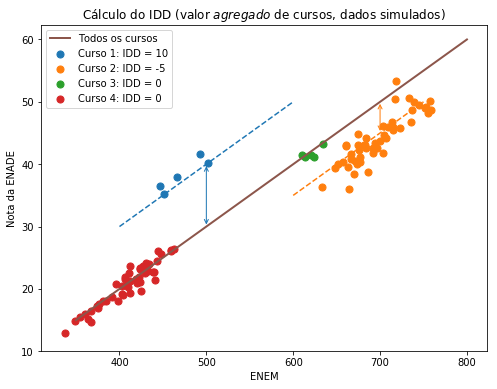

In [133]:
N1,N2,N3,N4 = 5,50,50,5 # alunos em cada grupo
intercept, beta = -20, 0.1 # enade = -20 + 0.1*enem (aprox os coeficientes reais)
idd1,idd2 = 10, -5 # "valor agregado" do curso 1 e 2
enem1 = 500 + 30*np.random.randn(N1)
enem2 = 700 + 30*np.random.randn(N2)
enem3 = 400 + 30*np.random.randn(N3)
enem4 = 600 + 30*np.random.randn(N4)
enem = np.array([350,800])
enem_1 = np.array([400,600])
enem_2 = np.array([600,750])
enem_3 = np.array([300,500])
enem_4 = np.array([500,850])

enade_m = enem*beta + intercept
enade_1 = enem_1*beta + intercept + idd1
enade_2 = enem_2*beta + intercept + idd2
enade1 = idd1 + enem1*beta + intercept + 2*np.random.randn(N1)
enade2 = idd2 + enem2*beta + intercept + 2*np.random.randn(N2)
enade3 = enem3*beta + intercept + 1*np.random.randn(N3)
enade4 = enem4*beta + intercept + 1*np.random.randn(N4)

fig = plt.figure(figsize=(8,6))
plt.plot(enem,enade_m,color="C5",linewidth=2,label="Todos os cursos")
plt.scatter(enem1,enade1,s=50,label="Curso 1: IDD = %i" % idd1)
plt.scatter(enem2,enade2,s=50,label="Curso 2: IDD = %i" % idd2)
plt.scatter(enem4,enade4,s=50,label="Curso 3: IDD = 0")
plt.scatter(enem3,enade3,s=50,label="Curso 4: IDD = 0")

plt.plot(enem_1,enade_1,'--',color='C0')
plt.plot(enem_2,enade_2,'--',color='C1')
ax = plt.gca()
ax.set_ylabel("Nota da ENADE")
ax.set_xlabel("ENEM")
ax.set_title("Cálculo do IDD (valor $agregado$ de cursos, dados simulados)")
ax.annotate("",xy=(500,intercept+500*beta),xytext=(500,intercept+idd1+500*beta),arrowprops=dict(arrowstyle='<->',color='C0'))
ax.annotate("",xy=(700,intercept+700*beta),xytext=(700,intercept+idd2+700*beta),arrowprops=dict(arrowstyle='<->',color='C1'))
ax.legend()

for dpi in [50,300]:
     fn = 'figs/idd-simulated-{}.png'.format(dpi)
     plt.savefig(fn,dpi=dpi)

Let's fit the above data with Lmer

In [134]:
data = pd.concat([pd.DataFrame({'enem':x,'enade':y,'curso':c}) for x,y,c in [(enem1,enade1,1),(enem2,enade2,2),(enem3,enade3,3),(enem4,enade4,4)] ])
import numpy as np
from pymer4.models import Lmer
import scipy.stats as stats
model = Lmer('enade ~ enem + (1|curso)',data=data)
model.fit()

Formula: enade ~ enem + (1|curso)

Family: gaussian	 Inference: parametric

Number of observations: 110	 Groups: {'curso': 4.0}

Log-likelihood: -218.761 	 AIC: 437.521

Random effects:

                 Name     Var    Std
curso     (Intercept)  56.201  7.497
Residual                2.471  1.572

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-21.572,-30.680,-12.464,4.647,6.651,-4.642,0.003,**
enem,0.105,0.095,0.115,0.005,107.915,21.125,0.000,***


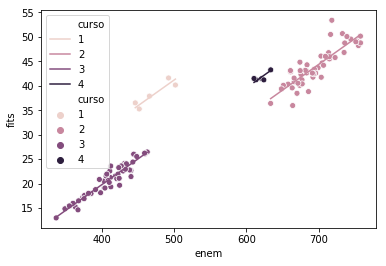

In [135]:
ax = sns.scatterplot(data = model.data, x='enem',y='enade',hue='curso')
sns.lineplot(data = model.data,x='enem',y='fits',hue='curso',ax=ax)

In the simulated data above, we depict four hypothecical courses with different kinds of students. It stands to reason the students of course 4 would score worse on the exit ENADE exam then the students of course 2. To take account of these differences in student characteristics, the IDD should "take into acccount" ou "control for" these differences. If, and this is obviously an unrealistic assumption, all differences not related to the quality of the course can be taken into account by the ENEM entrance exam, then we can calculate an aggregated value measure using the residuals of a regression on ENADE on ENEM. 

The INEP method takes the multilevel (or "random intercept") model and calculates the IDD as the mean of the residuals. This, of course, doesn't make any sense. Below, we use to different methods: one uses the estimated intercept directly and the other uses the average of the residuals with the main effect. These two methods give very similar results.

In [39]:
# IDD microdata
def getdata(ano,Nmin = 2):
    df = pd.read_csv("data/processed/idd-microdata-{}.csv".format(ano))
    df = df.dropna()
    df['anosgrad'] = df['ano'] - df['ingresso']
    df['enem'] = (df['mt'] + df['lc'] + df['ch'] + df['cn'])/4 # note that any missing enem subgrade will give a missing 'enem'
    df['ncurso'] = df.groupby('curso')['ano'].transform(lambda x: len(x))
    df = df[df['ncurso'] >= Nmin] # don't use courses with less than Nmin participants
    
    return df
    
data17 = getdata(2017,Nmin=2)
data14 = getdata(2014,Nmin=2)

# Published course IDD (only 2016 and 2017 available)
idd_inep17 = pd.read_csv('data/processed/idd-pub-2017.csv')
idd_inep17.dropna(inplace=True)

# Published course CPC (which includes a columns for "gross IDD")
cpc17 = pd.read_csv('data/processed/cpc-pub-2017.csv')
cpc14 = pd.read_csv('data/processed/cpc-pub-2014.csv')

def filtered(df,Nmin = 2):
    df = df[df['N'] >= Nmin]
    df = df[df['fracN'] >= 0.2]
    return df
cpc17 = filtered(cpc17)
cpc14 = filtered(cpc14)

In [40]:
print(len(data17),len(data17.dropna()))
print(len(data14),len(data14.dropna()))

283326 283326
143072 143072


In [41]:
data17.ncurso.describe()

count    283326.000000
mean        178.571829
std         589.801771
min           2.000000
25%          24.000000
50%          47.000000
75%          92.000000
max        4299.000000
Name: ncurso, dtype: float64

In [10]:
cpc17[cpc17['curso'] == 20709][:3]

,area,ies,curso,municipio,Nci,Ncp,enade,N,fracN,idd,cpc,cpcf,ano
7195,4006,1426,20709,5211503,37,33,1.641015,21.0,0.636364,-1.056711,2.061806,3,2017


In [11]:
N = 1
n17 = data17.groupby(['area','ies','municipio'])['curso'].nunique()
n171 = n17[n17==N]
print(len(n171))

n14 = data14.groupby(['area','ies','municipio'])['curso'].nunique()
n141 = n14[n14==N]
print(len(n141))

m = pd.concat([n141,n171],axis=1).reset_index()
len(m.dropna()) # 5452 "units of observation (area/institution/municipality) with only one course in both 2014 and 2017"

8472
6813


5452

In [42]:
# Let's characterize the data, to get an idea what we're dealing with
def summarize(data):
    ano = data['ano'][0]
    N = len(data)
    Ncursos = len(data.curso.unique())
    print("{}: {} students in {} unique courses".format(ano,N,Ncursos))
    print("ENADE:\n",data.nota.mean())
    print("ENEM:\n",data.enem.mean())
    print("\n")
summarize(data17)
summarize(data14)

c17 = set(data17.curso)
c14 = set(data14.curso)

print("Total unique courses:   ",len(c17 | c14))
print("Courses both in 2017 and 2014: ",len(c17 & c14))
print("Courses in 2017 but not in 2014: ",len(c17-c14))
print("Courses in 2014 but not in 2017: ",len(c14-c17))



2017: 283326 students in 9687 unique courses
ENADE:
 45.03252578302027
ENEM:
 551.8998259072588


2014: 143072 students in 7692 unique courses
ENADE:
 45.87724152874079
ENEM:
 539.764482218743


Total unique courses:    10976
Courses both in 2017 and 2014:  6403
Courses in 2017 but not in 2014:  3284
Courses in 2014 but not in 2017:  1289


In [119]:
import numpy as np
from pymer4.models import Lmer
import scipy.stats as stats

def multilevel(data,residcomoutlier = True):
    '''Retorna modelo1 (estimado com outliers) e modelo2 (estimado sem outliers).
    Retorna também os dados originais (com outliers!) e os residuos (calculado 
    pela diferença entre a nota original com a nota prevista pelo modelo2)
    
    Sim, isso não faz sentido.
    '''
    removeroutliers = True
    
    formula = 'nota ~ ch + cn + mt + lc + (1|curso)'
    model1 = Lmer(formula,data=data)
    _ = model1.fit(summarize=False);
    if removeroutliers:
        newdata = model1.data.copy()
        newdata['z'] = stats.zscore(newdata.residuals)
        newdata = newdata[abs(newdata.z) < 3]
        model2 = Lmer(formula,data=newdata)
        _ = model2.fit(summarize=False);
    else:
        model2 = model1
    
    model2.data = model2.data.rename(columns={'residuals':'resid'})
    if residcomoutlier:
        # Descobri que para reproduzir melhor os número do INEP, é preciso
        # *incluir* as notas dos outliers no cálculo do IDD (!)
        # Ou seja, vamos calcular a nota prevista pelo modelo2 (estimado sem outliers)
        # usando os todos os dados, incluindo outliers
        model1.data['pred'] = model2.predict(model1.data,use_rfx=True)
        model1.data['resid'] = model1.data.nota - model1.data.pred
        data = model1.data
    else:
        data = model2.data
    
    return model2,data
    
def idd_multilevel(data,Nmin,to_disk=True,verbose=False):
    'returns the idds calculated acording to INEP, and using the random intercepts'
    data = data.query("ncurso >= @Nmin")
    Ncursos = data.curso.nunique()
    if Ncursos < 2 or data.empty:
        return None,None,None
    area = data.area.iloc[0]
    if verbose:
        print("Area {}, with Nmin {} and Ncursos {}".format(area,Nmin,Ncursos))
    model,data = multilevel(data)
    d = {}
    for key in ['ml','intercept','noranef']:
        if key == 'ml':
            d[key] = data.groupby('curso').agg({'resid':['mean','size','std'],'enem':'mean','ies':'first','municipio':'first','adm':'first'})
        elif key == 'intercept':
            agg = data.groupby('curso').agg({'resid':['size','std'],'enem':'mean','ies':'first','municipio':'first','adm':'first'})
            agg.columns = ['N','std','enem.mean','ies','municipio','adm']
            agg.index = agg.index.astype(str)
            d[key] = model.ranef.join(agg)
            d[key].index.name = 'curso'
        elif key == 'noranef':
            model.data['pred'] = model.predict(model.data,use_rfx=False)
            model.data['resid'] = model.data.nota - model.data.pred
            d[key] = model.data.groupby('curso').agg({'resid':['mean','size','std'],'enem':'mean','ies':'first','municipio':'first','adm':'first'})

    
        d[key].columns = ['idd','N','std','enem.mean','ies','municipio','adm']
        d[key]['stderr'] = d[key]['std']/np.sqrt(d[key]['N'])
        d[key].sort_values('idd',ascending=False,inplace=True)
        d[key].insert(0,'rank',range(1,len(d[key])+1))
        area = data['area'].iloc[0]
        ano = data['ano'].iloc[0]
        d[key]['area'] = area
        d[key]['ano'] = ano

        if to_disk:
            fn = 'data/calculated/idd-'+key+'-'+str(ano)+'-'+str(area)+'-nmin-'+str(Nmin)+'.csv'
            d[key].reset_index().to_csv(fn,index=False)
    return d['ml'],d['intercept'],d['noranef']


In [89]:
area = 6405
model,data = multilevel(data17.query("area == @area"),residcomoutlier=False)
data[:3]

,ano,area,ies,catadm,orgacad,curso,municipio,ingresso,nota,cn,ch,lc,mt,adm,anosgrad,enem,ncurso,resid,fits,z
90,2017,6405,1,1,10028,10,5103403,2011,30.0,583.8,665.0,609.1,676.5,pub,6,633.60,40,-29.051078,59.051078,-2.810639
91,2017,6405,1,1,10028,10,5103403,2013,75.7,600.4,670.2,580.9,694.9,pub,4,636.60,40,16.278426,59.421574,1.593067
92,2017,6405,1,1,10028,10,5103403,2012,53.8,572.6,579.7,619.6,703.9,pub,5,618.95,40,-3.399274,57.199274,-0.332160


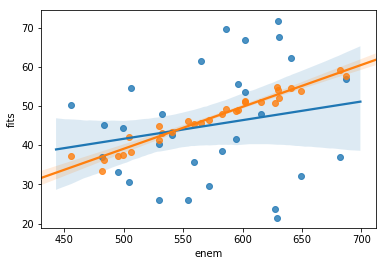

In [45]:
sns.regplot(data=data[data['curso'] == 12315],x='enem',y='nota')
sns.regplot(data=data[data['curso'] == 12315],x='enem',y='fits')
#sns.regplot(data=data[data['curso'] == 11992],x='enem',y='fits')

In [122]:
area = 2001
Nmin = 40
idd,idd_intercept,idd_noranef = idd_multilevel(data14.query("area == @area"),Nmin,verbose=True)

Area 2001, with Nmin 40 and Ncursos 174


In [123]:
idd[:3]

,rank,idd,N,std,enem.mean,ies,municipio,adm,stderr,area,ano
curso,,,,,,,,,,,
91776,1,1.550761,42,11.790755,485.733929,3588,2927408,priv_cfl,1.819353,2001,2014
97882,2,1.512042,48,9.924829,505.669792,521,3530607,priv_cfl,1.432526,2001,2014
5000402,3,1.475551,56,8.726715,502.802232,15121,4204202,pub,1.166156,2001,2014


In [75]:
idd_noranef[:3]

,rank,idd,N,std,enem.mean,ies,municipio,adm,stderr,area,ano
curso,,,,,,,,,,,
21627,1,9.832646,21,8.727194,628.598810,57,4115200,pub,1.904430,21,2017
106552,2,9.799263,38,9.992817,568.921053,664,3205200,priv_sfl,1.621049,21,2017
1150762,3,9.585143,36,8.450750,580.865972,17138,4209102,priv_sfl,1.408458,21,2017


In [58]:
areas17 = set(data17.area)
areas14 = set(data14.area)
areas = areas14 & areas17
areas = [area for area in areas]
s = pd.Series(areas,name='areas14-17')
s.to_csv('data/calculated/areas14-17.csv',index=False,header=True)

In [143]:
# this cell takes a long time to calculate. It writes the calcultations to disk.
#for Nmin in [50,20,10,2]:
for Nmin in [5,15,30,40]:
    %time _ = [idd_multilevel(data17.query('area == @area'),Nmin,verbose=True) for area in areas]
    %time _ = [idd_multilevel(data14.query('area == @area'),Nmin,verbose=True) for area in areas]

Area 3201, with Nmin 5 and Ncursos 49
Area 3202, with Nmin 5 and Ncursos 108
Area 6405, with Nmin 5 and Ncursos 61
Area 903, with Nmin 5 and Ncursos 20
Area 904, with Nmin 5 and Ncursos 257
Area 905, with Nmin 5 and Ncursos 204
Area 906, with Nmin 5 and Ncursos 81
Area 5902, with Nmin 5 and Ncursos 268
Area 21, with Nmin 5 and Ncursos 296
Area 5401, with Nmin 5 and Ncursos 67
Area 5402, with Nmin 5 and Ncursos 77
Area 6306, with Nmin 5 and Ncursos 217
Area 6307, with Nmin 5 and Ncursos 218
Area 4004, with Nmin 5 and Ncursos 279
Area 4005, with Nmin 5 and Ncursos 41
Area 4006, with Nmin 5 and Ncursos 400
Area 3502, with Nmin 5 and Ncursos 503
Area 5806, with Nmin 5 and Ncursos 314
Area 5814, with Nmin 5 and Ncursos 143
Area 3001, with Nmin 5 and Ncursos 60
Area 3002, with Nmin 5 and Ncursos 202
Area 701, with Nmin 5 and Ncursos 32
Area 702, with Nmin 5 and Ncursos 349
Area 6208, with Nmin 5 and Ncursos 452
Area 1601, with Nmin 5 and Ncursos 231
Area 1602, with Nmin 5 and Ncursos 399
Are

In [126]:
idd_calc_ml17 = pd.concat([pd.read_csv('data/calculated/idd-'+'ml-'+'2017-'+str(area)+'-nmin-2.csv') for area in areas])
idd_calc_ml14 = pd.concat([pd.read_csv('data/calculated/idd-'+'ml-'+'2014-'+str(area)+'-nmin-2.csv') for area in areas])

idd_calc_intercept17 = pd.concat([pd.read_csv('data/calculated/idd-'+'intercept-'+'2017-'+str(area)+'-nmin-2.csv') for area in areas])
idd_calc_intercept14 = pd.concat([pd.read_csv('data/calculated/idd-'+'intercept-'+'2014-'+str(area)+'-nmin-2.csv') for area in areas])


In [127]:
def iddcomp(mergedf):
    df = mergedf.rename(columns={'area_x':'area','idd_x':'idd_inep','idd_y':'idd_calc','N_x':'Ninep','N_y':'Ncalc'})
    df['z'] = stats.zscore(df.idd_inep)
    df['idd_diff'] = (df.idd_inep - df.idd_calc)
    df['idd_sdiff'] = (df.idd_inep - df.idd_calc)/np.sqrt(df.idd_inep.var() + df.idd_calc.var())
    return df

df = pd.merge(idd_inep17,idd_calc_ml17,on='curso')
iddcomp17 = iddcomp(df)
df = pd.merge(cpc14[cpc14.Ncursos == 1],idd_calc_ml14,on=['ies','municipio','area'],validate='1:m')
iddcomp14 = iddcomp(df)

iddcomp17.sort_values('idd_diff',ascending=False)[:10]

,area,curso,Ninep,idd_inep,ano_x,rank,idd_calc,Ncalc,std,enem.mean,ies,municipio,adm,stderr,area_y,ano_y,z,idd_diff,idd_sdiff
386,72,1166239,3.0,-6.267933,2017,346,-9.647069,3,21.269865,504.291667,519,2927408,priv_sfl,12.280162,72,2017,-2.507333,3.379136,0.954894
1083,702,1161404,10.0,-1.196584,2017,371,-3.267598,10,15.525200,563.032500,599,2905701,pub,4.909499,702,2017,-0.481173,2.071015,0.585238
3851,2001,21489,10.0,-4.478088,2017,1098,-6.494969,10,12.967000,492.840000,1396,4108304,priv_cfl,4.100526,2001,2017,-1.792235,2.016881,0.569941
5102,3201,45024,9.0,0.905321,2017,34,-1.051633,9,21.820640,626.172222,581,4314902,pub,7.273547,3201,2017,0.358603,1.956954,0.553006
2075,1402,42696,9.0,-0.187434,2017,152,-2.020923,9,18.081741,584.722222,585,4205407,pub,6.027247,1402,2017,-0.077987,1.833489,0.518117
876,701,13977,15.0,1.131569,2017,28,-0.615020,15,13.307235,648.228333,583,2304400,pub,3.435913,701,2017,0.448996,1.746589,0.493560
2018,1402,3146,10.0,-1.981849,2017,171,-3.702309,10,12.934139,605.307500,56,3543907,pub,4.090134,1402,2017,-0.794911,1.720460,0.486177
6346,4006,91181,13.0,0.889640,2017,295,-0.739644,13,12.070299,563.163462,1059,2304400,priv_cfl,3.347699,4006,2017,0.352337,1.629283,0.460411
2586,1601,1279265,9.0,-1.079072,2017,237,-2.688086,9,13.788898,549.588889,150,3552205,priv_sfl,4.596299,1601,2017,-0.434224,1.609014,0.454683
337,72,116390,14.0,0.161495,2017,268,-1.387605,14,10.935808,512.962500,316,3550308,priv_sfl,2.922718,72,2017,0.061421,1.549100,0.437753


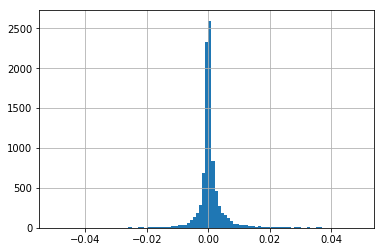

In [269]:
iddcomp17.idd_sdiff.hist(bins=np.arange(-0.05,0.05,0.001))

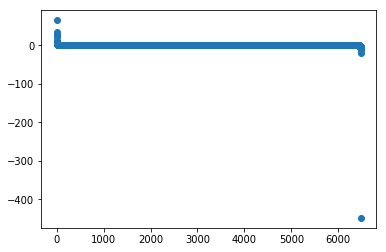

In [262]:
r = (iddcomp14.idd_inep/iddcomp14.idd_calc).sort_values(ascending=False)
plt.scatter(range(len(r)),r)

In [263]:
def Ndiffs(iddcomp,idd_sdiff=0.1,filter_z = False):
    Ncourses = len(iddcomp)
    if filter_z:
        iddcomp = iddcomp[abs(iddcomp['z']) < filter_z]
    print("Total number of courses",Ncourses)
    ndiff = len(iddcomp[abs(iddcomp['idd_sdiff'] > idd_sdiff)])
    print("Number courses which differ by at least {}: {}".format((idd_sdiff),ndiff))
    print("ratio:{:.2f}".format(ndiff/Ncourses))
    
Ndiffs(iddcomp14,0.05,filter_z = 3)

Total number of courses 6488
Number courses which differ by at least 0.05: 143
ratio:0.02


In [128]:
print("Total correlation 2017: ",iddcomp17[['idd_calc','idd_inep']].corr().iloc[0,1])
print("Total correlation 2014: ",iddcomp14[['idd_calc','idd_inep']].corr().iloc[0,1])

Total correlation 2017:  0.9991226843810065
Total correlation 2014:  0.9984033838989531


In [129]:
corrs17 = iddcomp17.groupby('area')[['idd_calc','idd_inep']].corr().iloc[0::2,-1].unstack()
corrs14 = iddcomp14.groupby('area')[['idd_calc','idd_inep']].corr().iloc[0::2,-1].unstack()
corrs = pd.merge(corrs17,corrs14,left_index=True,right_index=True)
corrs

,idd_calc_x,idd_calc_y
area,,
21,0.999963,0.999988
72,0.997115,0.999655
76,0.999932,0.997601
79,1.000000,0.999990
701,0.998267,0.996121
702,0.997566,0.999664
903,1.000000,0.999968
904,0.999793,0.999720
905,0.999989,0.999477


In [378]:
import matplotlib.pyplot as plt
import seaborn as sns

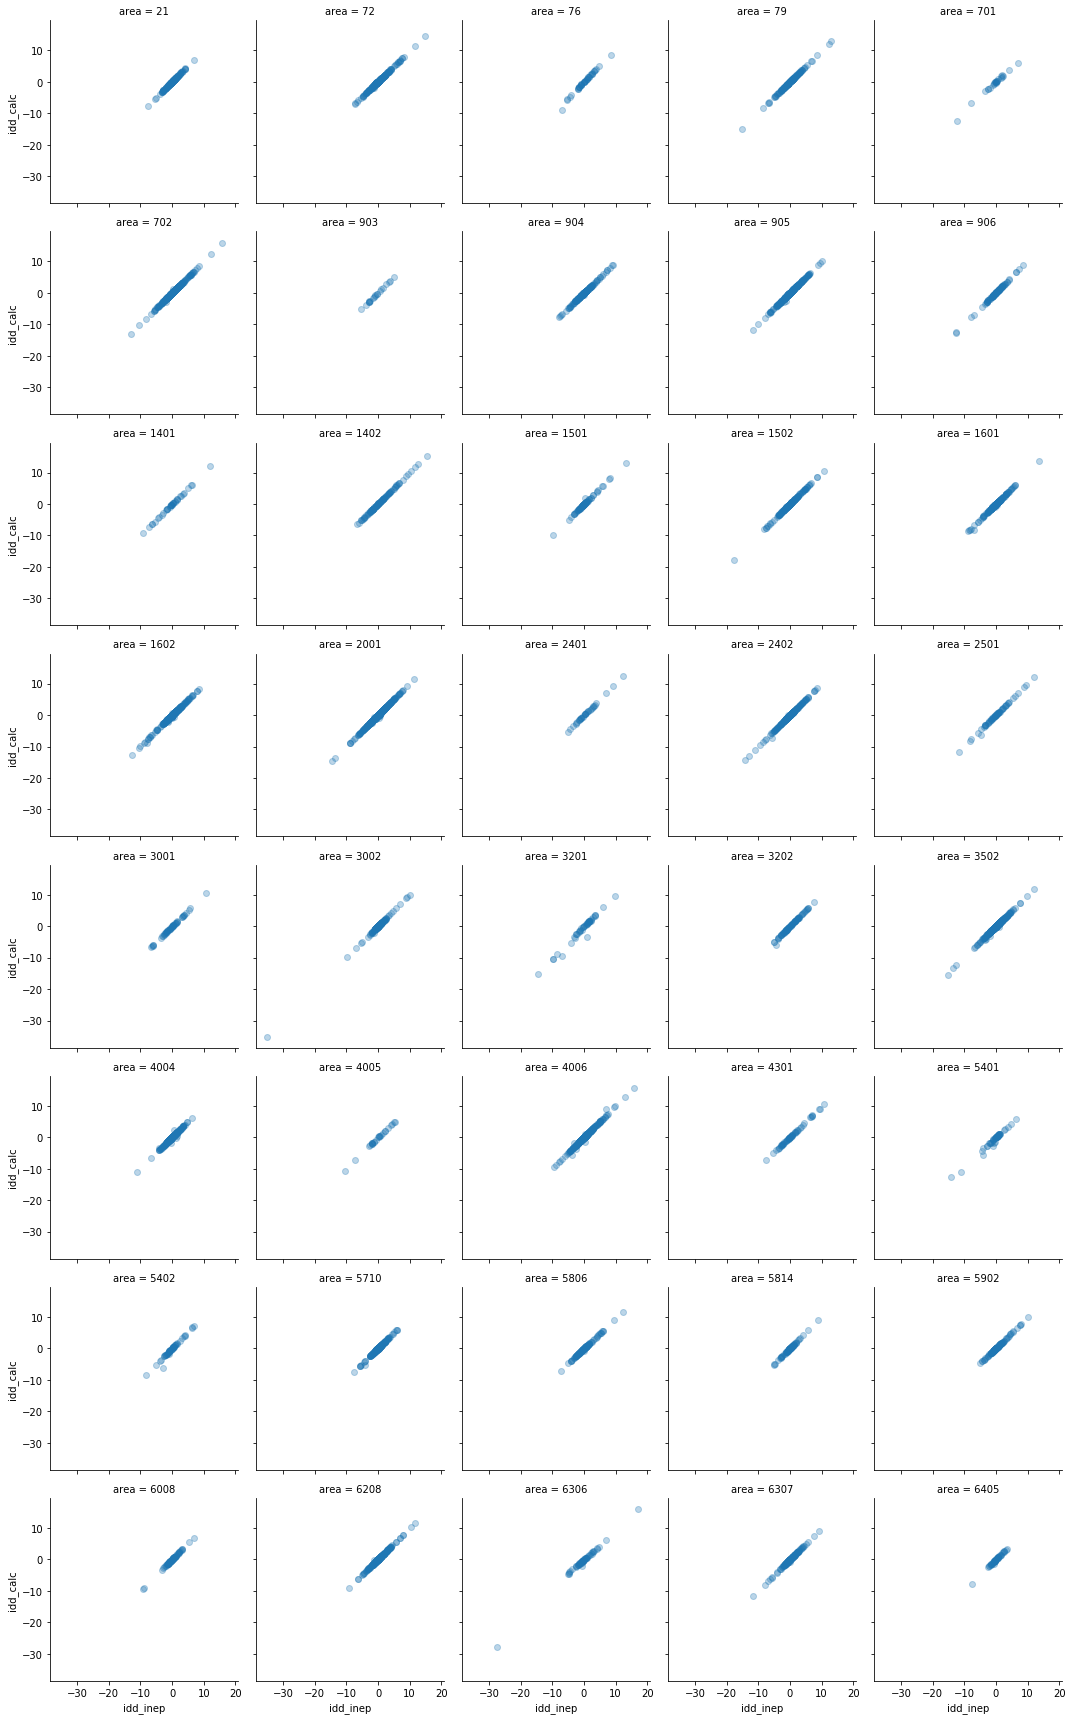

In [80]:
g = sns.FacetGrid(iddcomp14,col='area',height=3,col_wrap=5)
g.map(plt.scatter,'idd_inep','idd_calc',alpha=0.3);

/home/ewout/.conda/envs/idd/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


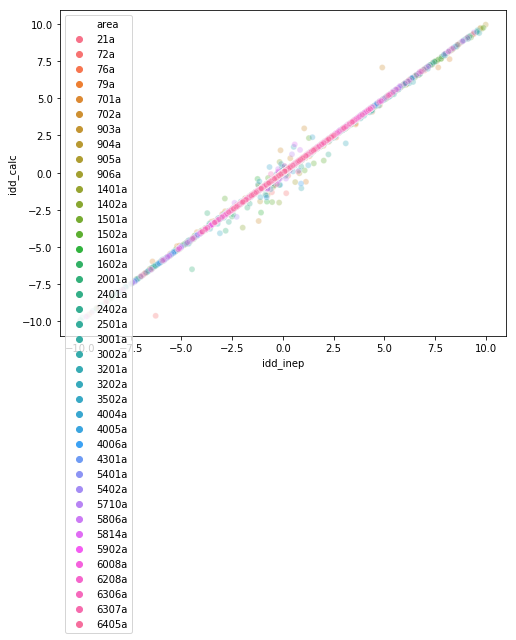

In [105]:
fig = plt.figure(figsize=(8,6))
data = iddcomp17[(iddcomp17['idd_inep'] < 10) & (iddcomp17['idd_inep'] > -10)]
data['area'] = data['area'].astype(str) + 'a'
sns.scatterplot(data = data,x='idd_inep',y='idd_calc',alpha=0.3,hue='area')

In [83]:
iddcomp17[['idd_inep','idd_calc']].describe()

,idd_inep,idd_calc
count,9333.000000,9333.000000
mean,0.003842,-0.001835
std,2.499305,2.495928
min,-30.671940,-30.674135
25%,-0.933147,-0.932737
50%,-0.084295,-0.086794
75%,0.858031,0.851030
max,20.863764,21.194490


In [233]:
iddcomp['diff'] = iddcomp['idd_calc'] - iddcomp['idd_inep']
iddcomp[abs(iddcomp['diff']) > 2]

,area,curso,Ninep,idd_inep,ano,rank,idd_sum,idd_calc,Ncalc,std,enem.mean,stderr,area_y,diff
404,72,1166239,3.0,-6.267933,2017,347,-28.897415,-9.632472,3,21.271670,504.291667,12.281204,72,-3.364539
1205,702,96955,9.0,4.891231,2017,6,63.656719,7.072969,9,11.008921,577.100000,3.669640,702,2.181737
1214,702,1161404,10.0,-1.196584,2017,382,-32.553798,-3.255380,10,15.516140,563.032500,4.906634,702,-2.058796
4290,2001,21489,10.0,-4.478088,2017,1105,-65.024795,-6.502480,10,12.966920,492.840000,4.100500,2001,-2.024392
8422,5806,50622,4.0,18.703827,2017,1,84.777961,21.194490,4,9.359645,652.656250,4.679823,5806,2.490664


In [235]:
model = multilevel(data17.query('area == 72'))

In [236]:
model.query('curso == 1166239')

,ano,area,ies,catacad,orgacad,curso,ingresso,nota,cn,ch,lc,mt,anosgrad,enem,ncurso,residuals,fits,pred,resid
259473,2017,72,519,5,10028,1166239,2015,43.0,509.1,511.2,561.1,534.2,2,528.900,3,7.254515,35.745485,39.264467,3.735533
259474,2017,72,519,5,10028,1166239,2015,37.5,513.8,572.8,494.3,423.8,2,501.175,3,4.588906,32.911094,35.971131,1.528869
259475,2017,72,519,5,10028,1166239,2015,0.0,477.0,461.9,479.5,512.8,2,482.800,3,-30.929815,30.929815,34.161817,-34.161817


In [237]:
model = multilevel(data17.query('area == 72'),residcomoutlier=False)
model.query('curso == 1166239')

,ano,area,ies,catacad,orgacad,curso,ingresso,nota,cn,ch,lc,mt,anosgrad,enem,ncurso,resid,fits,z
259473,2017,72,519,5,10028,1166239,2015,43.0,509.1,511.2,561.1,534.2,2,528.900,3,3.735533,39.264467,0.711127
259474,2017,72,519,5,10028,1166239,2015,37.5,513.8,572.8,494.3,423.8,2,501.175,3,1.528869,35.971131,0.449829


In [241]:
model = multilevel(data17.query('area == 72'),Nmin = 1)
model.query('curso == 1166239')

,ano,area,ies,catacad,orgacad,curso,ingresso,nota,cn,ch,lc,mt,anosgrad,enem,ncurso,residuals,fits,pred,resid
259473,2017,72,519,5,10028,1166239,2015,43.0,509.1,511.2,561.1,534.2,2,528.900,3,7.254515,35.745485,39.264467,3.735533
259474,2017,72,519,5,10028,1166239,2015,37.5,513.8,572.8,494.3,423.8,2,501.175,3,4.588906,32.911094,35.971131,1.528869
259475,2017,72,519,5,10028,1166239,2015,0.0,477.0,461.9,479.5,512.8,2,482.800,3,-30.929815,30.929815,34.161817,-34.161817


In [267]:
data14[:4]

,ano,area,ies,catacad,orgacad,curso,municipio,ingresso,nota,cn,ch,lc,mt,anosgrad,enem
0,2014,21,1,10002,10028,44,5103403,2010,66.9,695.9,693.4,688.3,764.0,4,710.400
1,2014,21,1,10002,10028,44,5103403,2010,52.7,676.0,703.8,726.9,588.7,4,673.850
2,2014,21,1,10002,10028,44,5103403,2010,58.2,720.5,728.5,670.2,691.0,4,702.550
3,2014,21,1,10002,10028,44,5103403,2010,62.0,653.3,676.6,662.5,543.5,4,633.975


In [286]:
idd_calc_ml14[:3]

,rank,idd_sum,idd,N,std,enem.mean,ies,municipio,stderr,area
curso,,,,,,,,,,
121602,1,29.221293,9.740431,3,14.128189,607.108333,582,4316907,8.156914,3201
349472,2,16.436348,8.218174,2,17.221034,631.650000,571,4106902,12.177110,3201
121366,3,18.530717,6.176906,3,7.202895,590.708333,2564,2504009,4.158594,3201


In [276]:
cpc14 = pd.read_csv('data/processed/cpc-pub-2014.csv')
cpc14[:3]

,area,ies,municipio,Ncursos,N,idd,ano
0,21,1,5103403,1,32,0.138465,2014
1,21,2,5300108,2,13,NaN,2014
2,21,3,2803609,1,6,NaN,2014


In [296]:
iddcomp14 = pd.merge(idd_calc_ml14.reset_index(),cpc14,on=['area','ies','municipio'],validate='m:1')
iddcomp14 = iddcomp14.rename(columns={'idd_x':'idd_calc','idd_y':'idd_inep'})
iddcomp14 = iddcomp14[iddcomp14['Ncursos']  == 1]
iddcomp14[:2]

,curso,rank,idd_sum,idd_calc,N_x,std,enem.mean,ies,municipio,stderr,area,Ncursos,N_y,idd_inep,ano
0,121602,1,29.221293,9.740431,3,14.128189,607.108333,582,4316907,8.156914,3201,1,3,9.883590,2014
2,121366,3,18.530717,6.176906,3,7.202895,590.708333,2564,2504009,4.158594,3201,1,3,6.155835,2014


In [297]:
corrs = iddcomp14.groupby('area')[['idd_calc','idd_inep']].corr().iloc[0::2,-1]
corrs = corrs.unstack()
corrs.sort_values('idd_calc')[:5]

,idd_calc
area,
5402,0.987227
3201,0.987779
5401,0.987902
4004,0.994418
701,0.996121


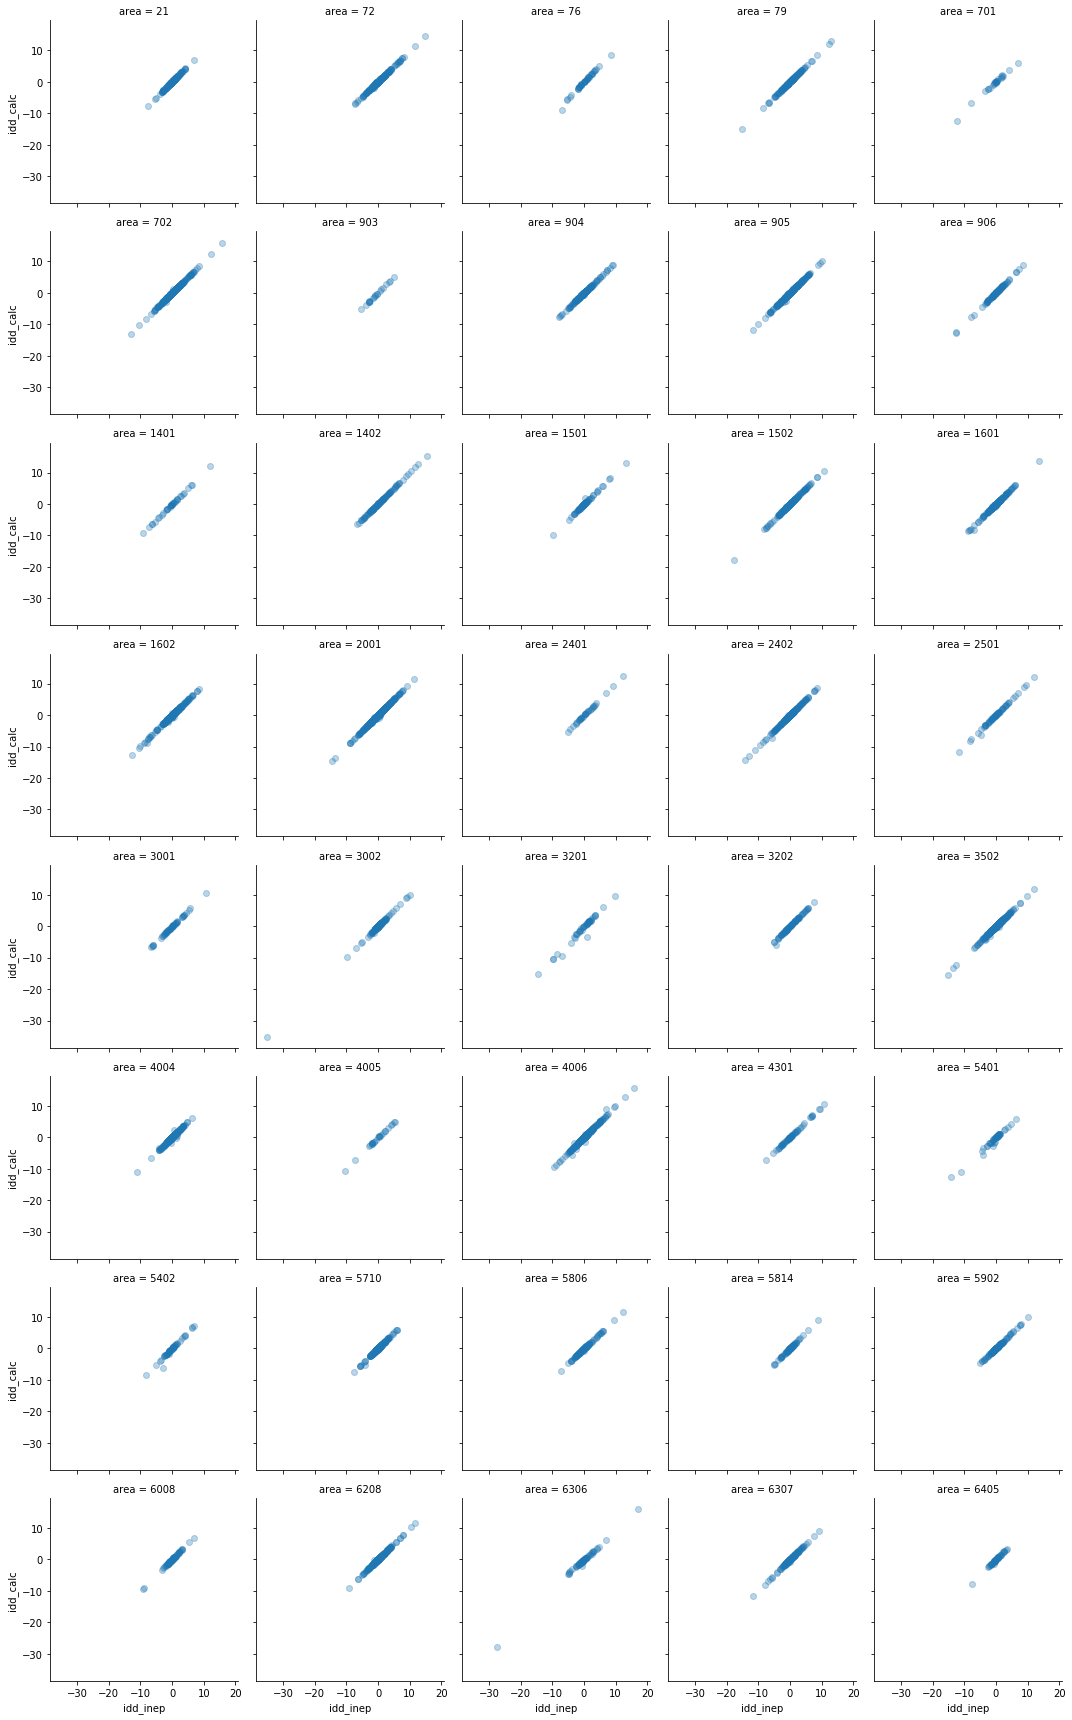

In [298]:
g = sns.FacetGrid(iddcomp14,col='area',height=3,col_wrap=5)
g.map(plt.scatter,'idd_inep','idd_calc',alpha=0.3);

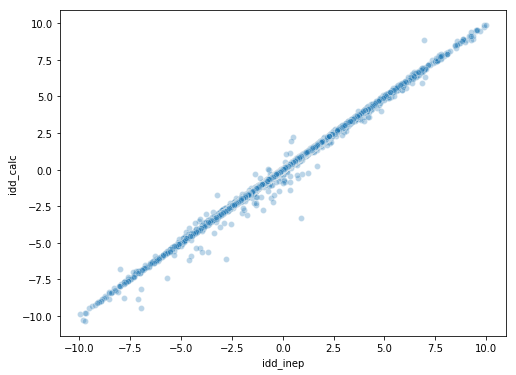

In [301]:
fig = plt.figure(figsize=(8,6))
data = iddcomp14[abs(iddcomp14['idd_inep']) < 10]
sns.scatterplot(data = data,x='idd_inep',y='idd_calc',alpha=0.3)

In [136]:
data17[:3]

,ano,area,ies,catadm,orgacad,curso,municipio,ingresso,nota,cn,ch,lc,mt,adm,anosgrad,enem,ncurso
0,2017,5710,1,1,10028,3,5103403,2011,75.1,612.5,745.0,641.0,765.6,pub,6,691.025,38
1,2017,5710,1,1,10028,3,5103403,2012,52.6,706.7,716.1,639.7,736.2,pub,5,699.675,38
2,2017,5710,1,1,10028,3,5103403,2012,50.5,545.3,594.0,600.7,745.3,pub,5,621.325,38


In [142]:
formula = 'nota ~ ch + cn + mt + lc + (1|adm/curso)'
model = Lmer(formula,data=data17.query("area == 21"))
model.fit()

Formula: nota ~ ch + cn + mt + lc + (1|adm/curso)

Family: gaussian	 Inference: parametric

Number of observations: 18218	 Groups: {'curso:adm': 301.0, 'adm': 3.0}

Log-likelihood: -68835.285 	 AIC: 137670.570

Random effects:

                  Name      Var     Std
curso:adm  (Intercept)    9.010   3.002
adm        (Intercept)    0.146   0.382
Residual                108.911  10.436

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-20.771,-22.473,-19.070,0.868,60.434,-23.930,0.0,***
ch,0.038,0.035,0.041,0.002,18083.268,25.207,0.0,***
cn,0.026,0.023,0.029,0.002,16607.974,15.495,0.0,***
mt,0.019,0.017,0.021,0.001,17798.309,18.579,0.0,***
lc,0.042,0.039,0.046,0.002,17674.230,24.263,0.0,***


In [141]:
model.summary()

Formula: nota ~ ch + cn + mt + lc + (1|curso)

Family: gaussian	 Inference: parametric

Number of observations: 18218	 Groups: {'curso': 301.0}

Log-likelihood: -68835.561 	 AIC: 137671.122

Random effects:

                 Name      Var     Std
curso     (Intercept)    9.121   3.020
Residual               108.907  10.436

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-20.976,-22.587,-19.364,0.822,9235.693,-25.515,0.0,***
ch,0.038,0.035,0.041,0.002,18123.528,25.227,0.0,***
cn,0.026,0.023,0.030,0.002,18205.967,15.582,0.0,***
mt,0.019,0.017,0.021,0.001,18198.174,18.641,0.0,***
lc,0.043,0.039,0.046,0.002,18195.327,24.331,0.0,***
